In [91]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("FoodPricePrediction").master('local[*]').getOrCreate()

# Load Data

In [4]:
path = '/content/drive/MyDrive/Distributed-Food-Price-Prediction-for-Kenyan-Markets/clean_data/food_combined_data.csv'


food_data = spark.read.csv(path, header=True, inferSchema=True)

In [5]:
food_data.show(30)

+----+-----+-------------+--------+--------------------+--------------------+--------------------+----------------+-----------+---------------+-----------+-------------+
|year|month|       region|  county|         market_name|       food_category|           food_item|measurement_unit|local_price|normalized_unit|rainfall_mm|temperature_c|
+----+-----+-------------+--------+--------------------+--------------------+--------------------+----------------+-----------+---------------+-----------+-------------+
|2022|  Dec|      Central|   Nyeri|    Karatina (Nyeri)|  cereals and tubers|Potatoes (Irish, ...|           50 KG|     2433.0|           50.0|      58.11|        25.35|
|2022|  Dec|      Central|   Nyeri|    Karatina (Nyeri)|vegetables and fr...|             Cabbage|          126 KG|     1512.0|          126.0|      58.11|        25.35|
|2022|  Dec|      Central|   Nyeri|    Karatina (Nyeri)|vegetables and fr...|                Kale|           50 KG|      750.0|           50.0|      5

In [6]:
food_data.count()

12824

In [7]:
food_data.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- region: string (nullable = true)
 |-- county: string (nullable = true)
 |-- market_name: string (nullable = true)
 |-- food_category: string (nullable = true)
 |-- food_item: string (nullable = true)
 |-- measurement_unit: string (nullable = true)
 |-- local_price: double (nullable = true)
 |-- normalized_unit: double (nullable = true)
 |-- rainfall_mm: double (nullable = true)
 |-- temperature_c: double (nullable = true)



In [8]:
food_data.describe().show()

+-------+------------------+-----+-----------+----------+--------------------+--------------------+-----------+----------------+------------------+-----------------+------------------+------------------+
|summary|              year|month|     region|    county|         market_name|       food_category|  food_item|measurement_unit|       local_price|  normalized_unit|       rainfall_mm|     temperature_c|
+-------+------------------+-----+-----------+----------+--------------------+--------------------+-----------+----------------+------------------+-----------------+------------------+------------------+
|  count|             12824|12824|      12824|     12824|               12824|               12824|      12824|           12824|             12824|            12824|             12824|             12824|
|   mean|2018.9509513412352| NULL|       NULL|      NULL|                NULL|                NULL|       NULL|            NULL|1925.4116055832822|30.76898783530906| 57.93680442918655|

In [9]:
from pyspark.sql.functions import col, count, avg, when
from pyspark.ml.feature import VectorAssembler

# Average local price per food category

In [10]:
avg_price_category = food_data.groupBy("food_category").agg(avg("local_price").alias("avg_price")).orderBy("avg_price", ascending=False)
avg_price_category.show()

+--------------------+------------------+
|       food_category|         avg_price|
+--------------------+------------------+
|     pulses and nuts| 4420.196906779662|
|vegetables and fr...| 1860.993284041898|
|  cereals and tubers|1499.2105812944635|
| meat, fish and eggs| 523.4563471971071|
|        oil and fats|222.92438016528928|
|            non-food| 90.30234693877549|
|      milk and dairy| 72.11717355371898|
|  miscellaneous food| 70.88697916666668|
+--------------------+------------------+



# local price by region

In [11]:
avg_price_region = food_data.groupBy("region").agg(avg("local_price").alias("avg_price")).orderBy("avg_price", ascending=False)
avg_price_region.show()

+-------------+------------------+
|       region|         avg_price|
+-------------+------------------+
|      Central|3945.3894117647064|
|       Nyanza|3247.9114943820236|
|      Eastern|2442.2042923433883|
|      Nairobi|1887.8263304633047|
|  Rift Valley| 1720.060297085196|
|North Eastern|1553.1491253101733|
|        Coast|1514.2071455756409|
+-------------+------------------+



## Convert month names to numbers

In [12]:
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Create a new column with numeric month values
food_data = food_data.withColumn('month_num',
                                 when(col('month') == 'Jan', 1)
                                 .when(col('month') == 'Feb', 2)
                                 .when(col('month') == 'Mar', 3)
                                 .when(col('month') == 'Apr', 4)
                                 .when(col('month') == 'May', 5)
                                 .when(col('month') == 'Jun', 6)
                                 .when(col('month') == 'Jul', 7)
                                 .when(col('month') == 'Aug', 8)
                                 .when(col('month') == 'Sep', 9)
                                 .when(col('month') == 'Oct', 10)
                                 .when(col('month') == 'Nov', 11)
                                 .when(col('month') == 'Dec', 12))

In [13]:
food_data.select('month', 'month_num').distinct().show(12)

+-----+---------+
|month|month_num|
+-----+---------+
|  Oct|       10|
|  Sep|        9|
|  May|        5|
|  Aug|        8|
|  Jun|        6|
|  Apr|        4|
|  Feb|        2|
|  Mar|        3|
|  Nov|       11|
|  Jul|        7|
|  Jan|        1|
|  Dec|       12|
+-----+---------+



# Assemble Features

In [14]:
feature_cols = ['year', 'month_num', 'region', 'rainfall_mm', 'temperature_c', 'normalized_unit']

In [16]:
from pyspark.ml.feature import StringIndexer


indexers = [StringIndexer(inputCol=col, outputCol=col + '_index').fit(food_data) for col in ['region']]
for indexer in indexers:
    food_data = indexer.transform(food_data)

In [17]:
assembler = VectorAssembler(inputCols=['year', 'month_num', 'region_index', 'rainfall_mm', 'temperature_c', 'normalized_unit'], outputCol='features')
data = assembler.transform(food_data).select('features', 'local_price')

In [18]:
data.show(5)

+--------------------+-----------+
|            features|local_price|
+--------------------+-----------+
|[2022.0,12.0,6.0,...|     2433.0|
|[2022.0,12.0,6.0,...|     1512.0|
|[2022.0,12.0,6.0,...|      750.0|
|[2022.0,12.0,6.0,...|      498.0|
|[2022.0,12.0,3.0,...|     2613.0|
+--------------------+-----------+
only showing top 5 rows



# Split data

In [19]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Define Random Forest model

In [20]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [21]:
rf = RandomForestRegressor(featuresCol='features', labelCol='local_price', numTrees=100, maxDepth=10)

# Train model

In [22]:
rf_model = rf.fit(train_data)

# Predictions

In [23]:
predictions = rf_model.transform(test_data)

# Evaluation

In [24]:
evaluator = RegressionEvaluator(labelCol='local_price', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

In [25]:
r2_evaluator = RegressionEvaluator(labelCol='local_price', predictionCol='prediction', metricName='r2')
r2 = r2_evaluator.evaluate(predictions)

In [26]:
print(f'Random Forest RMSE: {rmse:.2f}')
print(f'Random Forest R2 Score: {r2:.2f}')

Random Forest RMSE: 1417.08
Random Forest R2 Score: 0.79


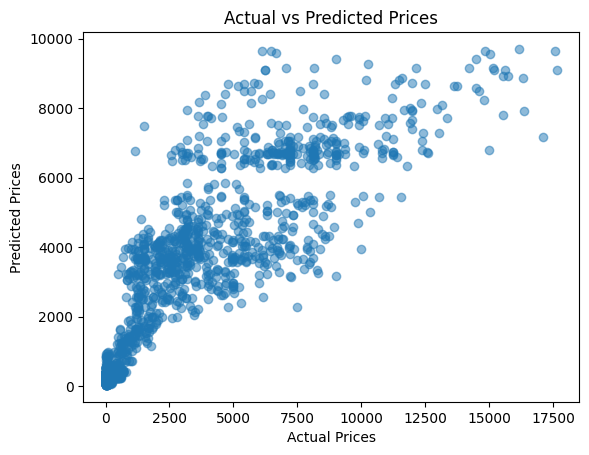

In [27]:
import matplotlib.pyplot as plt


preds_pd = predictions.select('local_price', 'prediction').toPandas()
plt.scatter(preds_pd['local_price'], preds_pd['prediction'], alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

# Save Model

In [29]:
rf_model.save('/content/drive/MyDrive/Distributed-Food-Price-Prediction-for-Kenyan-Markets/food_price_model')

# Git Version control

In [31]:
%cd /content/drive/MyDrive/Distributed-Food-Price-Prediction-for-Kenyan-Markets

/content/drive/MyDrive/Distributed-Food-Price-Prediction-for-Kenyan-Markets


In [32]:
!git pull origin main

From https://github.com/brc0d3s/Distributed-Food-Price-Prediction-for-Kenyan-Markets
 * branch            main       -> FETCH_HEAD
Already up to date.


In [34]:
!git config --global user.email "brc0d3s@gmail.com"
!git config --global user.name "brc0d3s"

In [ ]:
git add